<a href="https://colab.research.google.com/github/LOWKYA-M/hello-world/blob/master/fashion_minst.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import os 
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

In [0]:
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=0.5,std=0.5)
])
train_dataset=FashionMNIST(train=True,transform=transform,root=os.getcwd(),download=True)
test_dataset=FashionMNIST(train=False,transform=transform,root=os.getcwd(),download=True)

In [0]:
print("Train dataset:",train_dataset)
print("test dataset:",test_dataset)

Train dataset: Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: /content
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )
test dataset: Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: /content
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )


In [0]:
target_names = ['T-shirt/top', 
                'Trouser',
                'Pullover',
                'Dress',
                'Coat', 
                'Sandal',
                'Shirt',
                'Sneaker',
                'Bag',
                'Ankle boot']

In [0]:
train_loader=DataLoader(train_dataset,
                        batch_size=8,
                        shuffle=True,)
test_loader=DataLoader(test_dataset,
                       batch_size=8,
                       shuffle=False,)

In [0]:
image,label=next(iter(train_loader))
print(image.size(),label.size())

torch.Size([8, 1, 28, 28]) torch.Size([8])


In [0]:
def plot_images(images):
  img_grid=torchvision.utils.make_grid(images,nrow=4)
  img_np=img_grid.numpy()
  img_np=np.transpose(img_np,(1,2,0))

  mean,std=0.5,0.5
  img_np=img_np*std+mean

  plt.figure(figsize=(5,5))
  plt.imshow(img_np)
  plt.xticks([])
  plt.yticks([])
  plt.plot()

['Trouser', 'Pullover', 'Pullover', 'Shirt', 'Trouser', 'Shirt', 'T-shirt/top', 'T-shirt/top']


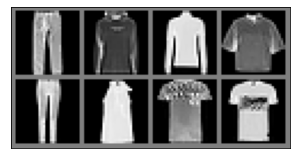

In [0]:
plot_images(image)
print([target_names[i] for i in label])

In [0]:
class NN(nn.Module):
  def __init__(self):
    super(NN, self).__init__()
    self.net=nn.Sequential(
        nn.Flatten(),

        nn.Linear(784,650),
        nn.Tanh(),

        nn.Linear(650,420),
        nn.Tanh(),

        nn.Linear(420,360),
        nn.LeakyReLU(),

        nn.Linear(360,230),
        nn.LeakyReLU(),

        nn.Linear(230,10),
        nn.Softmax(dim=1)
    )
  def forward(self,X):
    outs=self.net(X)
    return outs

In [0]:
device=torch.device('cuda:0' if torch.cuda.is_available() else'cpu')
device

device(type='cuda', index=0)

In [0]:
def evaluate_on_gpu(model,dataloader):
  with torch.no_grad():
    total,correct=0,0

    for batch in dataloader:
      images,labels=batch
      images,labels=images.to(device),labels.to(device)

      out_probs=model(images)
      out_labels=torch.argmax(out_probs,axis=1)
      total+=labels.size(0)
      correct+=torch.sum(labels==out_labels).item()

  return 100*correct/total

def train_on_gpu(model,model_name,loss_criterion,optimizer,train_loader,test_loader,epochs=150):
  hist={'loss':[],
        'train_acc':[],
        'test_acc':[]}

  min_loss=10e+10


  for epoch_num in tqdm(range(1,epochs+1),desc='Training',total=epochs):
    losses=[]
    for batch in train_loader:
      images,labels=batch
      images,labels=images.to(device),labels.to(device)

      optimizer.zero_grad()
      out=model(images)
      loss=loss_criterion(out,labels)
      losses.append(loss.item())
      loss.backward()

      optimizer.step()

    curr_epoch_loss=np.array(losses).mean()
    hist['loss'].append(curr_epoch_loss)
        #np.array(losses).mean())
    
    if curr_epoch_loss<min_loss:
      min_loss=curr_epoch_loss

      torch.save(model.state_dict(),model_name+'.pth')

    train_acc=evaluate_on_gpu(model,train_loader)
    test_acc=evaluate_on_gpu(model,test_loader)
    hist['train_acc'].append(train_acc)
    hist['test_acc'].append(test_acc)

  fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(14,7))
  ax[0].plot(range(1,epochs+1),hist['loss'],label='Loss') 
  ax[0].plot(range(1,epochs+1),np.ones(shape=(epochs,))*min_loss,'r--',alpha=0.5,label='Best Loss')                                                                                                                                                           
  ax[0].grid()
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Loss Value')
  ax[0].set_title('Epochs vs. Loss')

  ax[1].plot(hist['train_acc'],'b-',label='Training accuracy')
  ax[1].plot(hist['test_acc'],'m-',label='Test accuracy')
  ax[1].grid()
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Accuracy')
  ax[1].set_title('Epochs vs. Accuracy')
  plt.legend()
  plt.show()



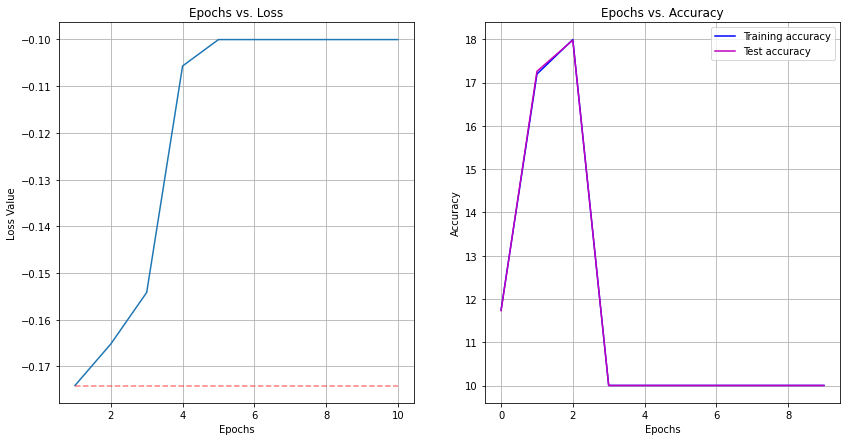

In [0]:
model=NN().to(device)
momentum=optim.SGD(model.parameters(),lr=0.01,momentum=0.980)
loss_fn=nn.NLLLoss()
train_on_gpu(model,
             'model_momentum',
              loss_fn,
              momentum,
              train_loader,
              test_loader,
              epochs=10)

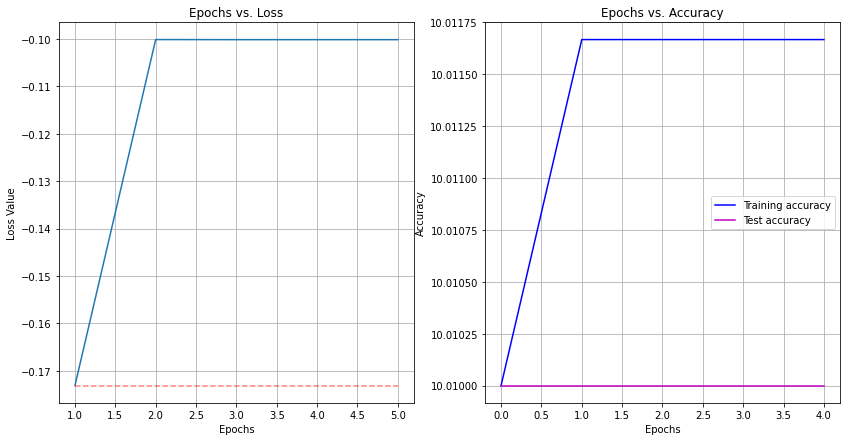

In [0]:
model=NN().to(device)
momentum=optim.SGD(model.parameters(),lr=0.01,momentum=0.980)
loss_fn=nn.NLLLoss()
train_on_gpu(model,
             'model_momentum',
              loss_fn,
              momentum,
              train_loader,
              test_loader,
              epochs=5)

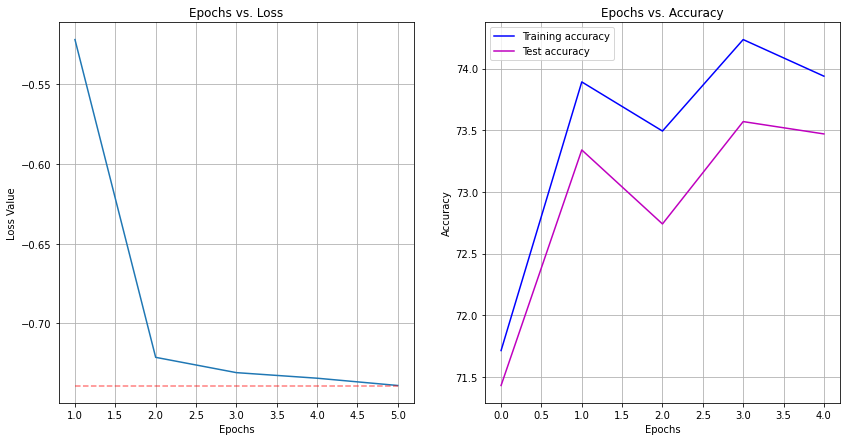

In [0]:
model=NN().to(device)
momentum=optim.SGD(model.parameters(),lr=0.0003,momentum=0.985)
loss_fn=nn.NLLLoss()
train_on_gpu(model,
             'model_momentum',
              loss_fn,
              momentum,
              train_loader,
              test_loader,
              epochs=5)

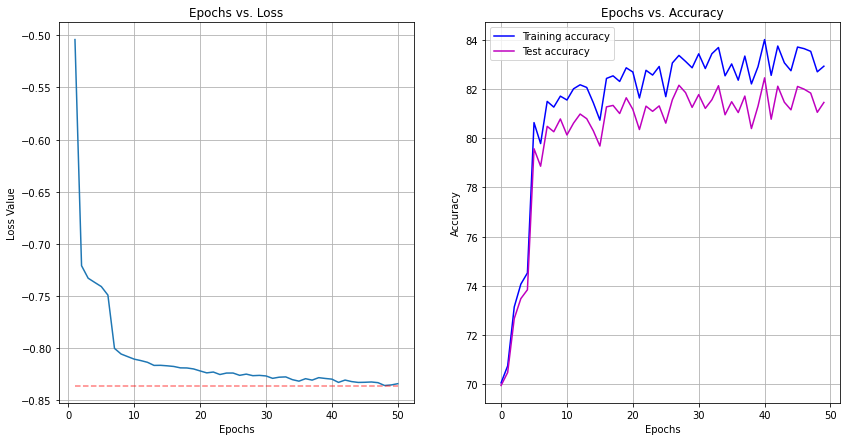

In [0]:
model=NN().to(device)
momentum=optim.SGD(model.parameters(),lr=0.0003,momentum=0.985)
loss_fn=nn.NLLLoss()
train_on_gpu(model,
             'model_momentum',
              loss_fn,
              momentum,
              train_loader,
              test_loader,
              epochs=50)

In [0]:
model=NN().to(device)

model.load_state_dict(torch.load('model_momentum.pth'))

<All keys matched successfully>

Predicted: ['Ankle boot', 'Coat', 'Trouser', 'Trouser', 'T-shirt/top', 'Trouser', 'Coat', 'Coat']
Actual: ['Ankle boot', 'Pullover', 'Trouser', 'Trouser', 'Shirt', 'Trouser', 'Coat', 'Shirt']


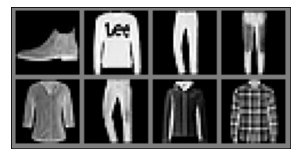

In [0]:
test_images,test_lables=next(iter(test_loader))
test_images,test_lables=test_images.to(device),test_lables.to(device)

plot_images(test_images.cpu())

out_probs=model(test_images)
out_labels=torch.argmax(out_probs,axis=1)

print('Predicted:',[target_names[i] for i in out_labels])
print('Actual:',[target_names[i] for i in test_lables])

In [0]:
print('Test Accuracy:',evaluate_on_gpu(model,test_loader))

Test Accuracy: 73.47
